<a href="https://colab.research.google.com/github/anny17/dog-and-cat-classification/blob/master/catanddog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 ! pip install -q kaggle

In [19]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anny17","key":"fd5cbafd9902f04422892872e5471cc9"}'}

In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [23]:
! kaggle datasets list

ref                                                       title                                               size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
dgomonov/new-york-city-airbnb-open-data                   New York City Airbnb Open Data                       2MB  2019-08-12 16:24:45          22658  
lakshyaag/india-trade-data                                India - Trade Data                                   1MB  2019-08-16 16:13:58          10833  
therohk/ireland-historical-news                           The Irish Times - Waxy-Wany News                    47MB  2019-08-24 15:36:54           2356  
dareenalharthi/jamalon-arabic-books-dataset               Jamalon Arabic Books Dataset                         1MB  2019-08-15 18:58:06            633  
rajeevw/ufcdata                                           UFC-Fight historical dat

In [25]:
! kaggle competitions download -c 'dogs-vs-cats'

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 71.9MB/s]
 95% 257M/271M [00:02<00:00, 83.6MB/s]
100% 271M/271M [00:02<00:00, 95.2MB/s]
 98% 534M/543M [00:03<00:00, 150MB/s]
100% 543M/543M [00:03<00:00, 156MB/s]


In [28]:
!mkdir dogandcat
!ls

mkdir: cannot create directory ‘dogandcat’: File exists
dogandcat  kaggle.json	sample_data  sampleSubmission.csv  test1.zip  train.zip


In [0]:
!cd dogandcat

In [0]:
!mkdir dogandcat/test

In [0]:
!unzip test1.zip -d dogandcat/test

In [0]:
!unzip train.zip -d dogandcat/train

In [0]:
import cv2
import os 
import numpy as np 
from random import shuffle 
from tqdm import tqdm 

In [0]:
TRAIN_DIR = 'dogandcat/train/train'
TEST_DIR = 'dogandcat/test/test1'
IMG_SIZE = 50
LR = 1e-3

In [0]:
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic')

In [0]:
def label_img(img):
  word_label = img.split('.')[-3]
  if word_label == 'cat': return [1,0]
  elif word_label == 'dog' : return [0,1]

In [0]:
def create_train_data():
  training_data = []
  for img in tqdm(os.listdir(TRAIN_DIR)):
    print(img)
    label = label_img(img)
    path = os.path.join(TRAIN_DIR,img)
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    training_data.append([np.array(img),np.array(label)])
  shuffle(training_data)
  np.save('train_data.npy',training_data)
  return training_data
create_train_data()

In [0]:
def process_test_data():
  testing_data = []
  for img in tqdm(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR,img)
    img_num = img.split('.')[0]
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    testing_data.append([np.array(img),img_num])
  shuffle(testing_data)
  np.save('test_data.npy', testing_data)
  return testing_data
process_test_data()

In [0]:
train_data = create_train_data()
test_data = process_test_data()

In [0]:
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

In [0]:
import tensorflow as tf

In [49]:
tf.reset_default_graph()
convnet = input_data(shape = [None,IMG_SIZE,IMG_SIZE,1], name = 'input')

convnet = conv_2d(convnet,32,5,activation = 'relu')
convnet = max_pool_2d(convnet,5)

convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet,0.8)

convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR,loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_dir ='log') 

train = train_data[:-500] 
test = train_data[-500:] 

X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
Y = [i[1] for i in train] 
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
test_y = [i[1] for i in test] 

model.fit({'input': X}, {'targets': Y}, n_epoch = 5, validation_set =({'input': test_x}, {'targets': test_y}),snapshot_step = 500, show_metric = True, run_id = MODEL_NAME) 
model.save(MODEL_NAME) 

Training Step: 1914  | total loss: 0.41308 | time: 80.304s
| Adam | epoch: 005 | loss: 0.41308 - acc: 0.8042 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.40967 | time: 81.518s
| Adam | epoch: 005 | loss: 0.40967 - acc: 0.8097 | val_loss: 0.51504 - val_acc: 0.7580 -- iter: 24500/24500
--
INFO:tensorflow:/content/dogsvscats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [0]:
X

In [0]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


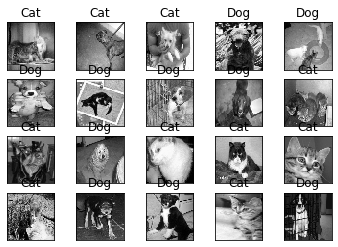

In [52]:
import matplotlib.pyplot as plt 
test_data = np.load('test_data.npy') 
  
fig = plt.figure() 
  
for num, data in enumerate(test_data[:20]):
  img_num = data[1] 
  img_data = data[0] 

  y = fig.add_subplot(4, 5, num + 1) 
  orig = img_data 
  data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 

  # model_out = model.predict([data])[0] 
  model_out = model.predict([data])[0] 

  if np.argmax(model_out) == 1: str_label ='Dog'
  else: str_label ='Cat'

  y.imshow(orig, cmap ='gray') 
  plt.title(str_label) 
  y.axes.get_xaxis().set_visible(False) 
  y.axes.get_yaxis().set_visible(False) 
plt.show() 